In [2]:
import json
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import glob
%matplotlib inline

sns.set(rc={'figure.figsize':(9, 3)})
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 600
BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Load LULESH data

In [3]:
def lines_that_start_with(string, fp):
    return [line for line in fp if line.startswith(string)]

data = []

for spread in [8,16,20,24,28,32]:
    
    for f in glob.glob(os.path.join(BASE_PATH, f'data/baseline/daint_mc/lulesh_64/lulesh_{spread}/lulesh_*.out')):

        with open(f, 'r') as fp:
            for line in lines_that_start_with("Elapsed time", fp):
                size = int(f.split('_')[-2])
                data.append([spread, size, float(line.split()[-2])])
                
lulesh_time = pd.DataFrame(data=data, columns=['spread', 'size', 'time'])
normal_lulesh = lulesh_time.loc[lulesh_time['spread'] == 32]

avg_lulesh = normal_lulesh.groupby(['size']).mean().reset_index()
median_lulesh = normal_lulesh.groupby(['size']).median().reset_index()
dev_lulesh = normal_lulesh.groupby(['size']).std().reset_index()

# Load NAS data

In [4]:

def lines_that_contain(string, fp):
    return [line for line in fp if string in line]

data = []

for p in [1,2,4,8]:
    
    for f in glob.glob(os.path.join(BASE_PATH, f'data/baseline/daint_mc/nas_sarus_{p}/*.out')):
        #print(f)
        with open(f, 'r') as fp:
            for line in lines_that_contain("in seconds", fp):
                size = f.split('_')[-2]
                benchmark = f.split('_')[-3]
                data.append([p, benchmark, size, float(line.split()[-1])])
                
nas_container = pd.DataFrame(data=data, columns=['p', 'benchmark', 'size', 'time'])
nas_container['type'] = nas_container.apply(lambda row: f"({row['benchmark'].upper()}, {row['size']})", axis=1)
nas_container.sort_values(by=['type'], inplace=True)
mean_container = nas_container.groupby(['benchmark', 'size', 'p']).mean()['time']
dev_container = nas_container.groupby(['benchmark', 'size', 'p']).std()['time']

#print('Mean', mean_container)
#print('CoV', nas_container.groupby(['benchmark', 'size', 'p']).std()['time'] / mean_container)
#print('Container/baremetal', mean_container/mean_baremetal)

mean_nas = nas_container.groupby(['benchmark', 'size', 'p']).mean().reset_index()
dev_nas = nas_container.groupby(['benchmark', 'size', 'p']).std().reset_index()
median_nas = nas_container.groupby(['benchmark', 'size', 'p']).median().reset_index()

# Load NAS co-location data

In [5]:

def lines_that_start_with(string, fp):
    return [line for line in fp if line.startswith(string)]

data = []

p_map = {
    'bt' : {
        'A': 4,
        'W': 1
    },
    'cg': {
        'B': 8
    },
    'ep': {
        'B': 2
    },
    'lu': {
        'A': 4
    },
    'mg': {
        'A': 1,
        'W': 1
    }
}

for dir in glob.glob(os.path.join(BASE_PATH, f'data/colocation_cpu_precision/lulesh/*')):
    
    name = os.path.basename(dir)
    
    app = name.split('_')[2]
    l_size = int(name.split('_')[1])
    bench_size = name.split('_')[3]
    
    for f in glob.glob(os.path.join(BASE_PATH, f'{dir}/nas_*.out')):
        #print(f)
        with open(f, 'r') as fp:
            for line in lines_that_contain("in seconds", fp):
                data.append([l_size, bench_size, app, p_map[app][bench_size], float(line.split()[-1])])
                
colocated_nas = pd.DataFrame(data=data, columns=['lulesh_size', 'size', 'benchmark', 'p', 'time'])
#print(colocated_nas)
#print(lulesh_time.loc[lulesh_time['size'] == 10]['time'])

mean_colocated_nas = colocated_nas.groupby(['benchmark', 'size', 'p', 'lulesh_size']).mean().reset_index()
dev_colocated_nas = colocated_nas.groupby(['benchmark', 'size', 'p', 'lulesh_size']).std().reset_index()
median_colocated_nas = colocated_nas.groupby(['benchmark', 'size', 'p', 'lulesh_size']).median().reset_index()

# Load LULESH co-location data

In [6]:
def lines_that_start_with(string, fp):
    return [line for line in fp if line.startswith(string)]

data = []



p_map = {
    'bt' : {
        'A': 4,
        'W': 1
    },
    'cg': {
        'B': 8
    },
    'ep': {
        'B': 2
    },
    'lu': {
        'A': 4
    },
    'mg': {
        'A': 1,
        'W': 1
    }
}

for dir in glob.glob(os.path.join(BASE_PATH, f'data/colocation_cpu_precision/lulesh/*')):
    
    name = os.path.basename(dir)
    
    app = name.split('_')[2]
    l_size = int(name.split('_')[1])
    bench_size = name.split('_')[3]
    
    for f in glob.glob(os.path.join(BASE_PATH, f'{dir}/lulesh_*.out')):
            
        with open(f, 'r') as fp:
            for line in lines_that_start_with("Elapsed time", fp):
                size = int(f.split('_')[-2])
                data.append([l_size, bench_size, app, float(line.split()[-2])])
                
colocated_lulesh = pd.DataFrame(data=data, columns=['size', 'benchmark_size', 'benchmark', 'time'])
avg_colocated_lulesh = colocated_lulesh.groupby(['size', 'benchmark', 'benchmark_size']).mean().reset_index()
median_colocated_lulesh = colocated_lulesh.groupby(['size', 'benchmark', 'benchmark_size']).median().reset_index()
dev_colocated_lulesh = colocated_lulesh.groupby(['size', 'benchmark', 'benchmark_size']).std().reset_index()


# Compute slowdown data

In [7]:
#print(dev_lulesh)
#print(dev_colocated_lulesh)

df1 = avg_colocated_lulesh.set_index('size')
#print(df1)
df2 = avg_lulesh.set_index('size')
df3 = dev_lulesh.set_index('size')
df4 = dev_colocated_lulesh.set_index('size')
df1['dev'] = df4['time'].reindex(df1.index)
df1['original_time'] = df2['time'].reindex(df1.index)
df1['original_dev'] = df3['time'].reindex(df1.index)
df1['slowdown'] = df1['time'] / df1['original_time']

df1['slowdown_dev'] = np.sqrt((df1['original_dev'] / df1['original_time'])**2 + (df1['dev'] / df1['time'])**2)

#print(df1)
#print(df2)
df3 = mean_colocated_nas.set_index(['benchmark', 'size', 'p'])
#print(df3)
df4 = mean_nas.set_index(['benchmark', 'size', 'p'])
df10 = dev_nas.set_index(['benchmark', 'size', 'p'])
df11 = dev_colocated_nas.set_index(['benchmark', 'size', 'p'])
#print(df4)
df3['original_dev'] = df10['time'].reindex(df3.index)
df3['original_time'] = df4['time'].reindex(df3.index)
df3['slowdown'] = df3['time'] / df3['original_time']
df3['dev'] = df11['time'].reindex(df3.index)
df3['slowdown_dev'] = np.sqrt((df3['original_dev'] / df3['original_time'])**2 + (df3['dev'] / df3['time'])**2)
#print(df3)
df5 = df1.reset_index().rename(columns={"size": "lulesh_size"})
df6 = df3.reset_index().rename(columns={"size": "benchmark_size"})

df5 = df5.set_index(['benchmark', 'benchmark_size', 'lulesh_size'])
df6 = df6.set_index(['benchmark', 'benchmark_size', 'lulesh_size'])
#print(df5)
#print('-')
#print(df6)

df5['nas_slowdown'] = df6['slowdown'].reindex(df5.index)
df5['nas_slowdown_dev'] = df6['slowdown_dev'].reindex(df5.index)
#print(df5)
df5.reset_index(inplace=True)

p_map = {
    'bt' : {
        'A': 4,
        'W': 1
    },
    'cg': {
        'B': 8
    },
    'ep': {
        'B': 2
    },
    'lu': {
        'A': 4
    },
    'mg': {
        'A': 1,
        'W': 1
    }
}
df5['p'] = df5[['benchmark', 'benchmark_size']].apply(lambda x: p_map[x['benchmark']][x['benchmark_size']], axis=1)
#df5['p'] = p_map[df5['benchmark']][df5['bench_size']]
df5['type'] = df5.apply(lambda row: f"({row['benchmark'].upper()}, {row['benchmark_size']}, {row['p']})", axis=1)
df5.sort_values(by=['type'], inplace=True)
#print(df5)
#print(df5)
df5['rescaled_slowdown'] = (df5['slowdown']-1)*100
df5['rescaled_nas_slowdown'] = (df5['nas_slowdown']-1)*100
df5['rescaled_slowdown_dev'] = df5['slowdown_dev']*100
df5['rescaled_nas_slowdown_dev'] = df5['nas_slowdown_dev']*100
print(df5)
df5_modified = df5.drop(df5.loc[df5['type'] == '(MG, A, 1)'].index)

   benchmark benchmark_size  lulesh_size        time        dev  \
0         bt              A           15   40.677667   0.500435   
21        bt              A           25  295.591566   1.597424   
14        bt              A           20  119.864287   0.735505   
7         bt              A           18   77.959563   0.393864   
1         bt              W           15   40.504664   0.392733   
15        bt              W           20  120.322426   0.720762   
22        bt              W           25  295.647019   1.425129   
8         bt              W           18   78.059868   0.454771   
16        cg              B           20  122.234282   3.765780   
23        cg              B           25  297.945357   1.271533   
2         cg              B           15   41.492239   1.830090   
9         cg              B           18   78.779812   0.540605   
10        ep              B           18   78.234147   0.743515   
3         ep              B           15   40.180077   0.20129

# Plot LULESH

In [8]:
def barplot_err(x, y, xerr=None, yerr=None, data=None, **kwargs):

    _data = []
    for _i in data.index:

        _data_i = pd.concat([data.loc[_i:_i]]*3, ignore_index=True, sort=False)
        _row = data.loc[_i]
        if xerr is not None:
            _data_i[x] = [_row[x]-_row[xerr], _row[x], _row[x]+_row[xerr]]
        if yerr is not None:
            _data_i[y] = [_row[y]-_row[yerr], _row[y], _row[y]+_row[yerr]]
        _data.append(_data_i)

    _data = pd.concat(_data, ignore_index=True, sort=False)

    _ax = sns.barplot(x=x,y=y,data=_data,ci='sd',**kwargs)

    return _ax


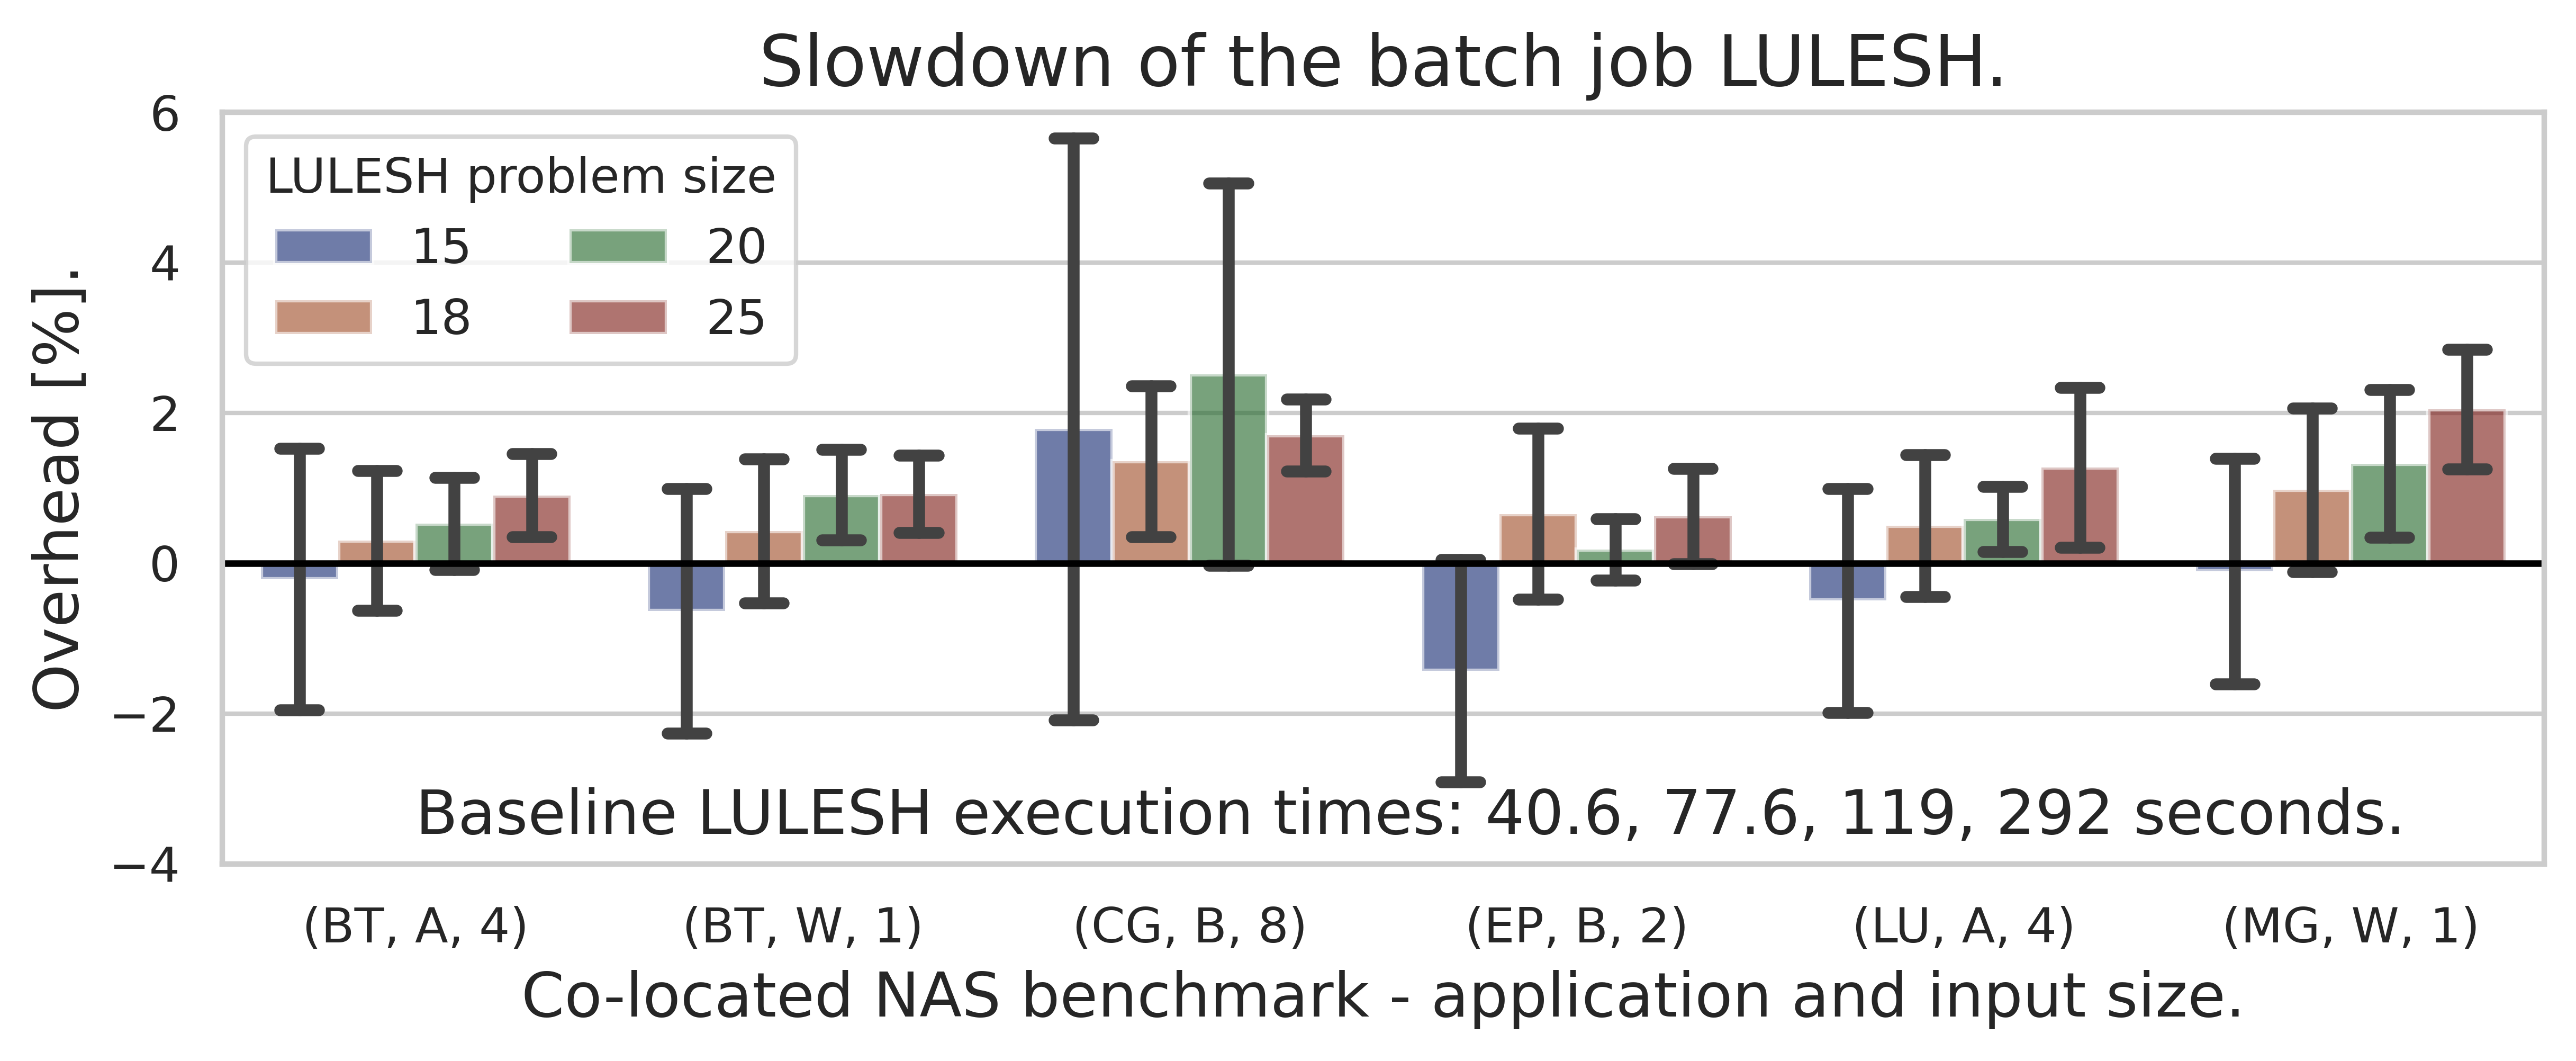

In [9]:

fig = plt.figure(figsize=(8.5,3.5))
ax = fig.gca()
#g = sns.barplot(
#    data=df5_modified,
#    x="type", y="slowdown", hue="lulesh_size",
#    ci="sd", palette="dark", alpha=.6, #size=.5,#height=6,
#    ax=ax, yerr=df5_modified['slowdown_dev']*1
#)

g = barplot_err(y="rescaled_slowdown", x="type", yerr="rescaled_slowdown_dev", hue="lulesh_size",
                data=df5_modified,palette="dark", alpha=.6, capsize=0.1)
g.set_xlabel('Co-located NAS benchmark - application and input size.',fontsize=14)
g.set_ylabel('Overhead [%].',fontsize=14)
g.set_title('Slowdown of the batch job LULESH.',fontsize=16)
g.legend(title='LULESH problem size', ncol=2, fontsize=11,title_fontsize=11)
#plt.legend.set_title('LULESH problem size',prop={'fontsize':14})
g.set_ylim([-4,6])
g.axhline(y=0, color='black', linestyle='-')


def errplot(x, y, yerr, **kwargs):
    ax = plt.gca()
    data = kwargs.pop("data")
    print(data)
    data.plot(x=x, y=y, yerr=yerr, kind="bar", ax=ax, **kwargs)
#ax.map_dataframe(errplot, "type", "slowdown", "slowdown_dev")


plt.annotate("Baseline LULESH execution times: 40.6, 77.6, 119, 292 seconds.",
             #r'Free memory in $\bf{allocated}$'+'\n'+r'and $\bf{idle}$ nodes.',
             xy=(0.5, -2),  #xycoords='data',
            xytext=(0, -3.6), fontsize=14,
    #textcoords='axes fraction',
            #arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)

plt.tight_layout()
plt.savefig(os.path.join('plots', "colocation_cpu_lulesh.pdf"),bbox_inches='tight',pad_inches = 0, transparent=False)

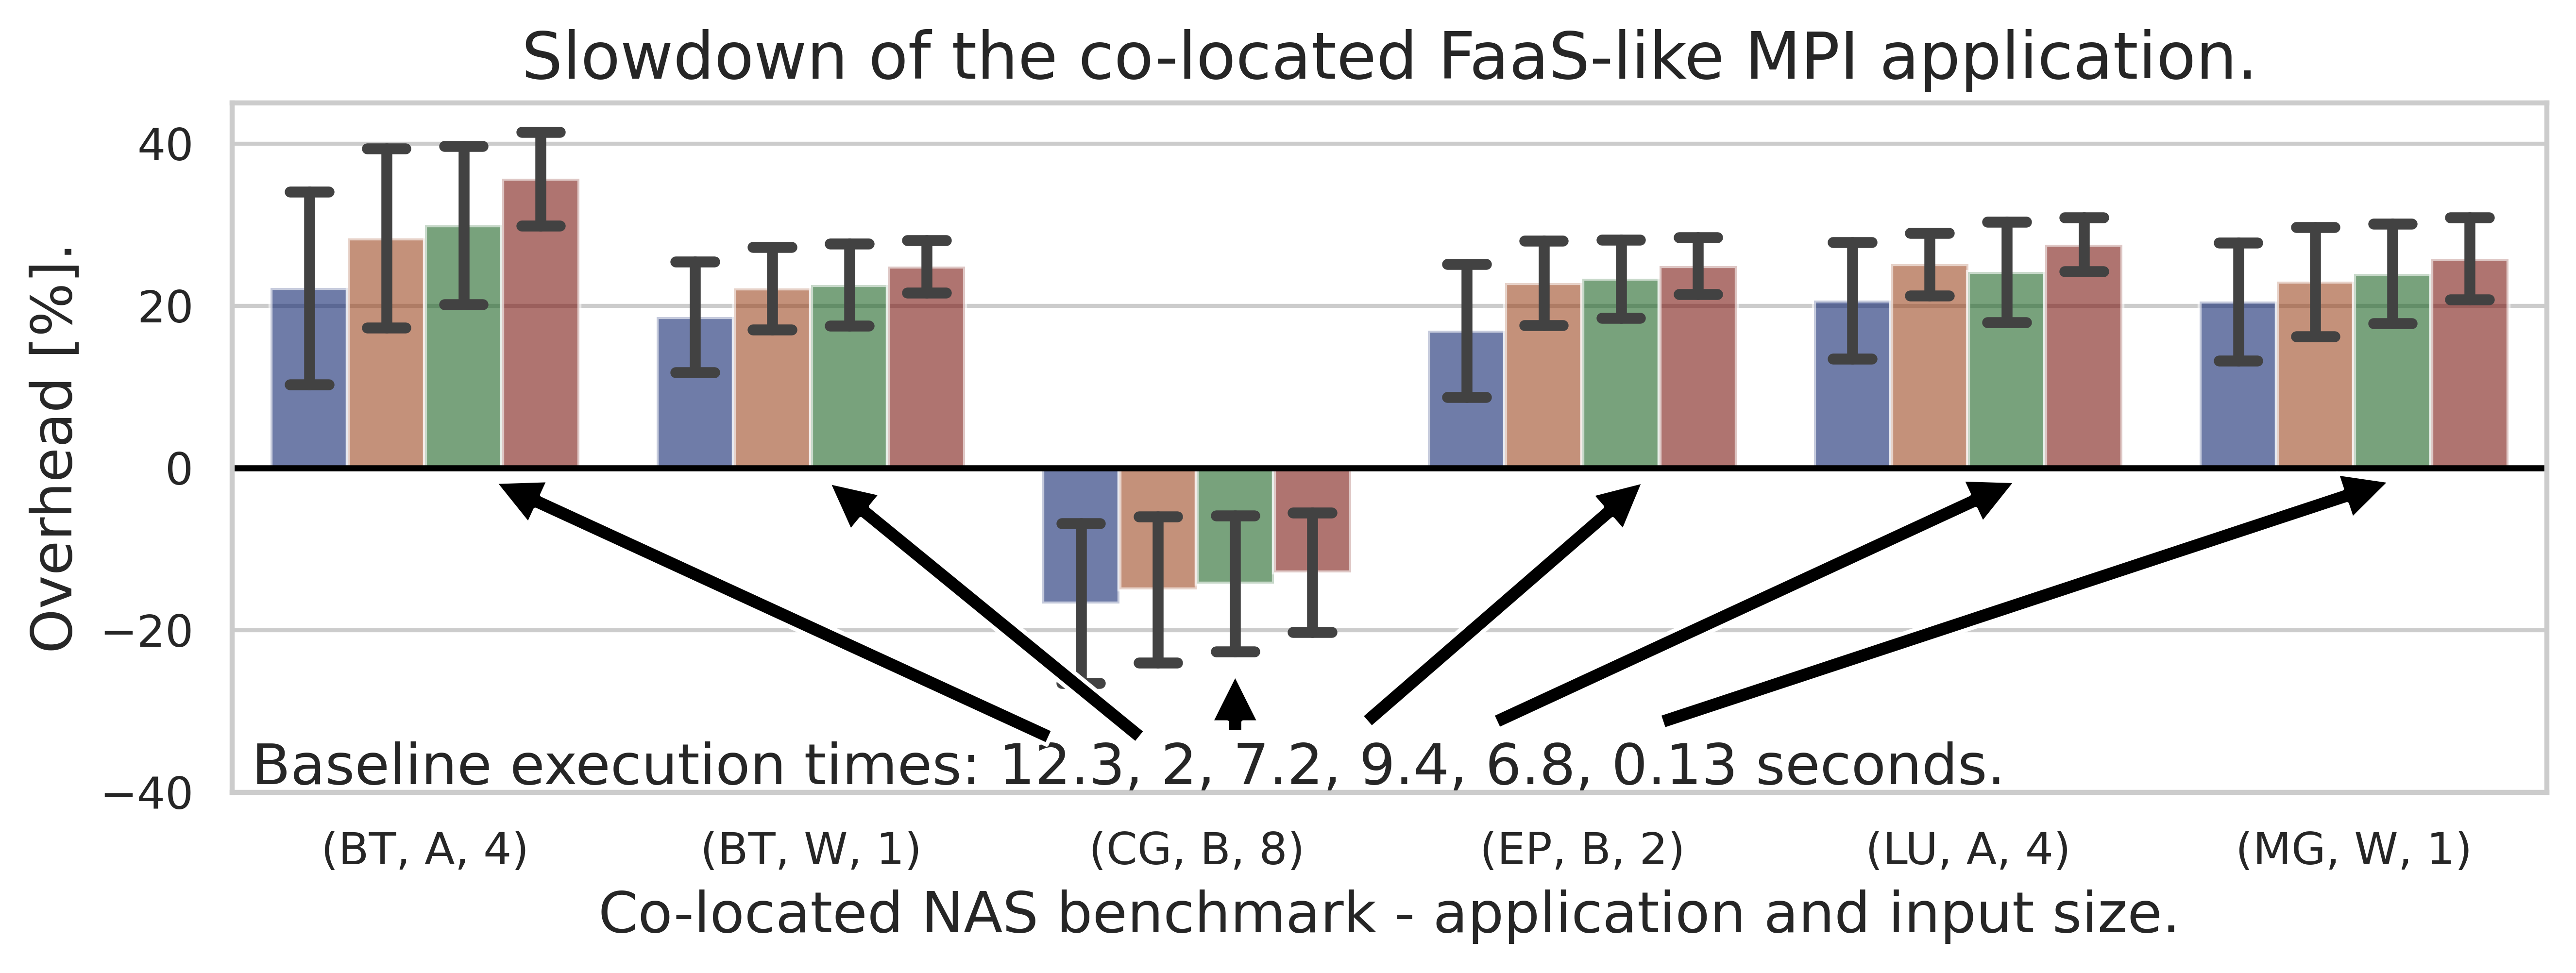

In [10]:

sns.set_style("whitegrid")
fig = plt.figure(figsize=(9,3.5))
ax = fig.gca()
#g = sns.barplot(
#    data=df5_modified,
#    x="type", y="nas_slowdown", hue="lulesh_size",
#    ci="sd", palette="dark", alpha=.6, #, alpha=.6, height=6,
#    ax=ax
#)
g = barplot_err(y="rescaled_nas_slowdown", x="type", yerr="rescaled_nas_slowdown_dev",
                hue="lulesh_size", data=df5_modified,palette="dark", alpha=.6, capsize=0.1)

g.set_ylabel('Overhead [%].',fontsize=14)
g.set_title('Slowdown of the co-located FaaS-like MPI application.',fontsize=16)
g.legend().set_visible(False)
g.axhline(y=0, color='black', linestyle='-')
g.set_ylim([-40, 45])
g.set_xlabel('Co-located NAS benchmark - application and input size.',fontsize=14)


plt.annotate("Baseline execution times: 12.3, 2, 7.2, 9.4, 6.8, 0.13 seconds.",
             #r'Free memory in $\bf{allocated}$'+'\n'+r'and $\bf{idle}$ nodes.',
             xy=(0.5, -2),  #xycoords='data',
            xytext=(-0.45, -39), fontsize=14,
    #textcoords='axes fraction',
            #arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)
plt.annotate("", xy=(0.1, 0),  #xycoords='data',
            xytext=(1.7, -35),
            arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)
plt.annotate("", xy=(1, 0),  #xycoords='data',
            xytext=(1.9, -35),
            arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)
plt.annotate("", xy=(2.1, -25),  #xycoords='data',
            xytext=(2.1, -33),
            arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)
plt.annotate("", xy=(3.2, 0),  #xycoords='data',
            xytext=(2.4, -33),
            arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)
plt.annotate("", xy=(4.2, 0),  #xycoords='data',
            xytext=(2.7, -33),
            arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)
plt.annotate("", xy=(5.2, 0),  #xycoords='data',
            xytext=(3.1, -33),
            arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)


plt.tight_layout()
plt.savefig(os.path.join('plots', "colocation_cpu_lulesh_nas.pdf"),bbox_inches='tight',pad_inches = 0, transparent=False)

# Load MILC data

In [11]:
data = []
for f in glob.glob(os.path.join(BASE_PATH, f'data/baseline/daint_mc/milc_64/milc_32/milc_*.out')):

    with open(f, 'r') as fp:
        for line in lines_that_start_with("Elapsed total time", fp):
            size = int(f.split('_')[-2])
            data.append([32, size, float(line.split()[-1])])
            
normal_milc_mc = pd.DataFrame(data=data, columns=['ranks_per_node', 'size', 'time'])
normal_milc_mc['system'] = 'daint-mc'
normal_milc_mc['type'] = 'baseline'
normal_milc_mc['benchmark'] = 'milc'
normal_milc_mc['application'] = 'milc'
normal_milc_mc['benchmark-type'] = normal_milc_mc.apply(lambda row: f"({row['benchmark'].upper()}, {row['application'].upper()}, {row['size']})", axis=1)
normal_milc_mc['ranks'] = 64
normal_milc_mc['nodes'] = 2

avg_milc = normal_milc_mc.groupby(['size']).mean().reset_index()
median_milc = normal_milc_mc.groupby(['size']).median().reset_index()
dev_milc = normal_milc_mc.groupby(['size']).std().reset_index()

# Load MILC co-location data

In [12]:
def lines_that_start_with(string, fp):
    return [line for line in fp if line.startswith(string)]

data = []


p_map = {
    'bt' : {
        'A': 4,
        'W': 1
    },
    'cg': {
        'B': 8
    },
    'ep': {
        'B': 2
    },
    'lu': {
        'A': 4
    },
    'mg': {
        'A': 1,
        'W': 1
    }
}

for dir in glob.glob(os.path.join(BASE_PATH, f'data/colocation_cpu_precision/milc/*')):
    
    name = os.path.basename(dir)
    
    app = name.split('_')[2]
    l_size = int(name.split('_')[1])
    bench_size = name.split('_')[3]
    
    for f in glob.glob(os.path.join(BASE_PATH, f'{dir}/milc_*.out')):
            
        with open(f, 'r') as fp:
            for line in lines_that_start_with("Elapsed total time", fp):
                size = int(f.split('_')[-2])
                data.append([l_size, bench_size, app, float(line.split()[-1])])

colocated_milc = pd.DataFrame(data=data, columns=['size', 'benchmark_size', 'benchmark', 'time'])                
avg_colocated_milc = colocated_milc.groupby(['size', 'benchmark', 'benchmark_size']).mean().reset_index()
median_colocated_milc = colocated_milc.groupby(['size', 'benchmark', 'benchmark_size']).median().reset_index()
dev_colocated_milc = colocated_milc.groupby(['size', 'benchmark', 'benchmark_size']).std().reset_index()

# Load NAS co-location data

In [13]:

def lines_that_start_with(string, fp):
    return [line for line in fp if line.startswith(string)]

data = []

p_map = {
    'bt' : {
        'A': 4,
        'W': 1
    },
    'cg': {
        'B': 8
    },
    'ep': {
        'B': 2
    },
    'lu': {
        'A': 4
    },
    'mg': {
        'A': 1,
        'W': 1
    }
}

for dir in glob.glob(os.path.join(BASE_PATH, f'data/colocation_cpu_precision/milc/*')):
    
    name = os.path.basename(dir)
    
    app = name.split('_')[2]
    l_size = int(name.split('_')[1])
    bench_size = name.split('_')[3]
    
    for f in glob.glob(os.path.join(BASE_PATH, f'{dir}/nas_*.out')):
        #print(f)
        with open(f, 'r') as fp:
            for line in lines_that_contain("in seconds", fp):
                data.append([l_size, bench_size, app, p_map[app][bench_size], float(line.split()[-1])])
                
colocated_nas_milc = pd.DataFrame(data=data, columns=['milc_size', 'size', 'benchmark', 'p', 'time'])

mean_colocated_nas_milc = colocated_nas_milc.groupby(['benchmark', 'size', 'p', 'milc_size']).mean().reset_index()
dev_colocated_nas_milc = colocated_nas_milc.groupby(['benchmark', 'size', 'p', 'milc_size']).std().reset_index()
median_colocated_nas_milc = colocated_nas_milc.groupby(['benchmark', 'size', 'p', 'milc_size']).median().reset_index()

# Compute slowdown data

In [14]:

df1 = avg_colocated_milc.set_index('size')
df2 = avg_milc.set_index('size')
df3 = dev_milc.set_index('size')
df4 = dev_colocated_milc.set_index('size')
df1['dev'] = df4['time'].reindex(df1.index)
df1['original_time'] = df2['time'].reindex(df1.index)
df1['original_dev'] = df3['time'].reindex(df1.index)
df1['slowdown'] = df1['time'] / df1['original_time']

df1['slowdown_dev'] = np.sqrt((df1['original_dev'] / df1['original_time'])**2 + (df1['dev'] / df1['time'])**2)

print(df1)
print(df2)

df3 = mean_colocated_nas_milc.set_index(['benchmark', 'size', 'p'])
print(df3)
df4 = mean_nas.set_index(['benchmark', 'size', 'p'])
df10 = dev_nas.set_index(['benchmark', 'size', 'p'])
df11 = dev_colocated_nas_milc.set_index(['benchmark', 'size', 'p'])
#print(df4)
df3['original_dev'] = df10['time'].reindex(df3.index)
df3['original_time'] = df4['time'].reindex(df3.index)
df3['slowdown'] = df3['time'] / df3['original_time']
df3['dev'] = df11['time'].reindex(df3.index)
df3['slowdown_dev'] = np.sqrt((df3['original_dev'] / df3['original_time'])**2 + (df3['dev'] / df3['time'])**2)
print(df3)

df5 = df1.reset_index().rename(columns={"size": "milc_size"})
df6 = df3.reset_index().rename(columns={"size": "benchmark_size"})
print(df6)

df5 = df5.set_index(['benchmark', 'benchmark_size', 'milc_size'])
df6 = df6.set_index(['benchmark', 'benchmark_size', 'milc_size'])
print(df5)
print('-')
print(df6)

df5['nas_slowdown'] = df6['slowdown'].reindex(df5.index)
df5['nas_slowdown_dev'] = df6['slowdown_dev'].reindex(df5.index)
print(df5)
df5.reset_index(inplace=True)

p_map = {
    'bt' : {
        'A': 4,
        'W': 1
    },
    'cg': {
        'B': 8
    },
    'ep': {
        'B': 2
    },
    'lu': {
        'A': 4
    },
    'mg': {
        'A': 1,
        'W': 1
    }
}
df5['p'] = df5[['benchmark', 'benchmark_size']].apply(lambda x: p_map[x['benchmark']][x['benchmark_size']], axis=1)
#df5['p'] = p_map[df5['benchmark']][df5['bench_size']]
df5['type'] = df5.apply(lambda row: f"({row['benchmark'].upper()}, {row['benchmark_size']}, {row['p']})", axis=1)
df5.sort_values(by=['type'], inplace=True)
print(df5)

print(df5)
df5['rescaled_slowdown'] = (df5['slowdown']-1)*100
df5['rescaled_nas_slowdown'] = (df5['nas_slowdown']-1)*100
df5['rescaled_slowdown_dev'] = df5['slowdown_dev']*100
df5['rescaled_nas_slowdown_dev'] = df5['nas_slowdown_dev']*100
print(df5)

df5_modified = df5.drop(df5.loc[df5['type'] == '(MG, A, 1)'].index)

     benchmark benchmark_size        time        dev  original_time  \
size                                                                  
32          bt              A   92.263732  22.851391      87.155905   
32          bt              W   87.610899   1.162911      87.155905   
32          cg              B   89.759592   2.488727      87.155905   
32          ep              B   86.460632   1.841430      87.155905   
32          lu              A   86.438093   0.165291      87.155905   
32          mg              A   87.973872   1.127458      87.155905   
32          mg              W   89.560359   1.014670      87.155905   
64          bt              A  178.498148  51.771556     168.985498   
64          bt              W  166.617567   2.782889     168.985498   
64          cg              B  170.556660   2.080400     168.985498   
64          ep              B  163.159834   4.675944     168.985498   
64          lu              A  162.166209   1.462746     168.985498   
64    

# Plot MILC

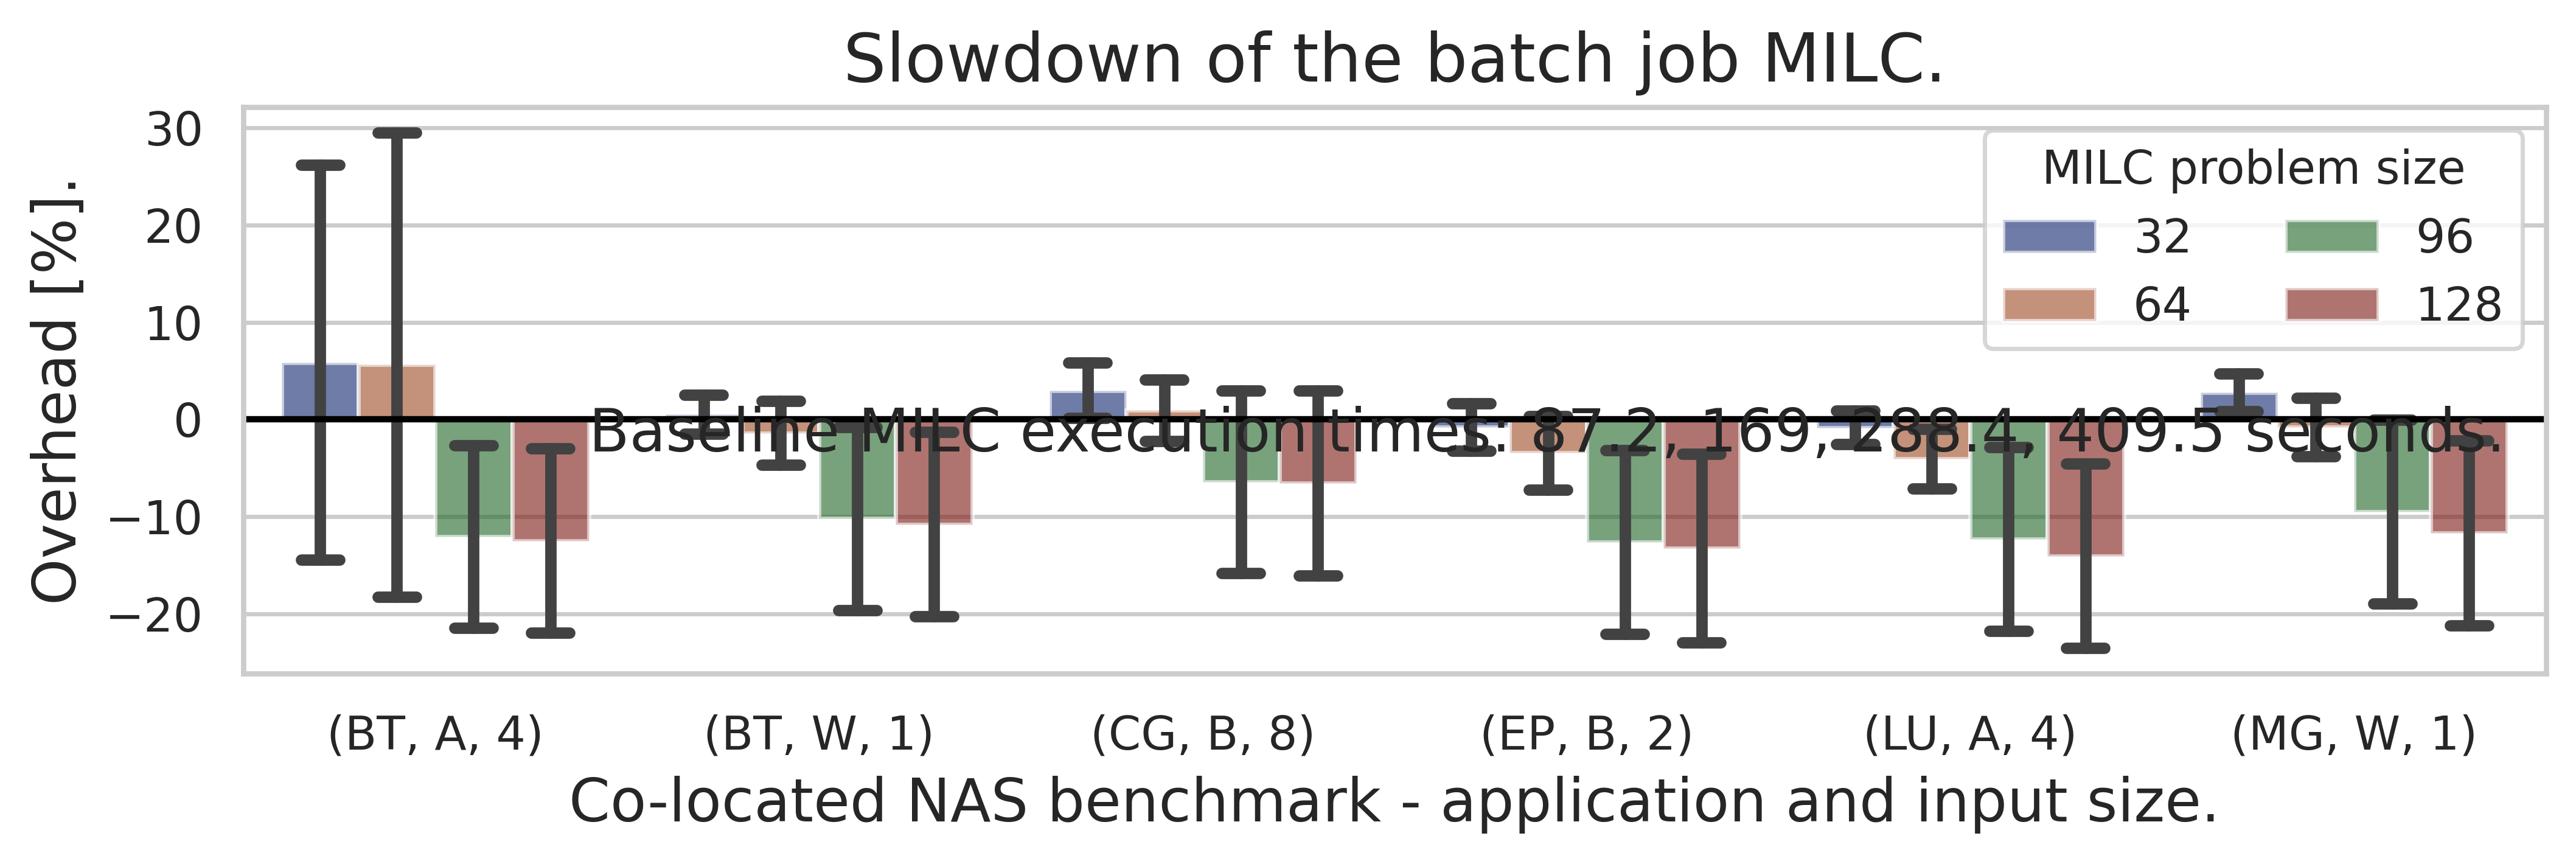

In [16]:
fig = plt.figure(figsize=(9,3))
ax = fig.gca()

g = barplot_err(y="rescaled_slowdown", x="type", yerr="rescaled_slowdown_dev", hue="milc_size",
                data=df5_modified,palette="dark", alpha=.6, capsize=0.1)
g.set_xlabel('Co-located NAS benchmark - application and input size.',fontsize=14)
g.set_ylabel('Overhead [%].',fontsize=14)
g.set_title('Slowdown of the batch job MILC.',fontsize=16)
g.legend(title='MILC problem size', ncol=2, fontsize=11,title_fontsize=11)
#plt.legend.set_title('LULESH problem size',prop={'fontsize':14})
#g.set_ylim([-15,8])
g.axhline(y=0, color='black', linestyle='-')


plt.annotate("Baseline MILC execution times: 87.2, 169, 288.4, 409.5 seconds.",
             #r'Free memory in $\bf{allocated}$'+'\n'+r'and $\bf{idle}$ nodes.',
             xy=(0.5, -2),  #xycoords='data',
            xytext=(0.4, -3.3), fontsize=14,
    #textcoords='axes fraction',
            #arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)

plt.rcParams['figure.dpi'] = 500
plt.tight_layout()
plt.savefig(os.path.join('plots', "colocation_cpu_milc.pdf"),bbox_inches='tight',pad_inches = 0, transparent=False)